<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/mri_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resampling MRI:<br>
Modifying voxel spacing, origin, get direction of a MRI following a reference MRI<br>
Download public MRIs and my reference MRI:

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=12VsmYrHN-a0OzVlwP8CxkuAK4zTfMaaC'
gdown.download(url,'pituitary_public.zip',quiet=True)
!unzip -q pituitary_public.zip


url = 'https://drive.google.com/uc?id=1QwB-DFkvDHR0kqVffLrqDGJ3xY-47yJ6'
gdown.download(url,'ref_mri.nii.gz',quiet=True)

'ref_mri.nii.gz'

Installing lib:

In [2]:
!pip -q install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.7 MB/s eta 0:00:00


Resampling: Modifying voxel spacing, origin, get direction of a MRI following a reference MRI

In [3]:
import nibabel as nib
from glob import glob
import numpy as np
import os
import SimpleITK as sitk

def get_resampling(ref_mri, mri, path):
    mri.SetSpacing(ref_mri.GetSpacing())
    #  mri.SetDirection(ref_mri.GetDirection())
    mri.SetOrigin(ref_mri.GetOrigin())
    writer = sitk.ImageFileWriter()
    writer.SetFileName(path)
    writer.Execute(mri)


ref_mri = sitk.ReadImage('ref_mri.nii.gz')

#resampling mri
path_all = glob('pituitary_public/*/*T1_C.nii')
for path in path_all:
    print('mri to resample:', path)
    mri = sitk.ReadImage(path)
    path = path.replace('pituitary_public', 'pituitary_resampled')
    os.makedirs(os.path.dirname(path), exist_ok = True)
    path = path.replace(os.path.basename(path), os.path.basename(os.path.dirname(path))+'_t1c.nii.gz')
    get_resampling(ref_mri, mri, path)
    print('saved in:', path)

#resampling mask
path_all = glob('pituitary_public/*/mask.nii')
for path in path_all:
    print('mri to resample:', path)
    mri = sitk.ReadImage(path)
    path = path.replace('pituitary_public', 'pituitary_resampled')
    os.makedirs(os.path.dirname(path), exist_ok = True)
    path = path.replace(os.path.basename(path), os.path.basename(os.path.dirname(path))+'_mask.nii.gz')
    get_resampling(ref_mri, mri, path)
    print('saved in:', path)

mri to resample: pituitary_public/mri_010/COR_T1_C.nii
saved in: pituitary_resampled/mri_010/mri_010_t1c.nii.gz
mri to resample: pituitary_public/mri_012/COR_T1_C.nii
saved in: pituitary_resampled/mri_012/mri_012_t1c.nii.gz
mri to resample: pituitary_public/mri_001/COR_T1_C.nii
saved in: pituitary_resampled/mri_001/mri_001_t1c.nii.gz
mri to resample: pituitary_public/mri_003/COR_T1_C.nii
saved in: pituitary_resampled/mri_003/mri_003_t1c.nii.gz
mri to resample: pituitary_public/mri_014/COR_T1_C.nii
saved in: pituitary_resampled/mri_014/mri_014_t1c.nii.gz
mri to resample: pituitary_public/mri_004/COR_T1_C.nii
saved in: pituitary_resampled/mri_004/mri_004_t1c.nii.gz
mri to resample: pituitary_public/mri_008/COR_T1_C.nii
saved in: pituitary_resampled/mri_008/mri_008_t1c.nii.gz
mri to resample: pituitary_public/mri_007/COR_T1_C.nii
saved in: pituitary_resampled/mri_007/mri_007_t1c.nii.gz
mri to resample: pituitary_public/mri_005/COR_T1_C.nii
saved in: pituitary_resampled/mri_005/mri_005_t1c

slicing: public dataset

voxel size: (512, 512, 11)


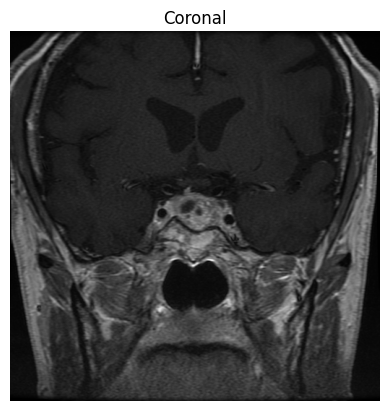

In [25]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

path = '/content/pituitary_resampled/mri_001/mri_001_t1c.nii.gz'
mri = nib.load(path).get_fdata()
mri = np.rot90(mri, k=3)
mri = cv2.normalize(mri, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print('voxel size:',mri.shape)

cv2.imwrite('test_cv2.png', mri[:,:, 5])
plt.imshow(mri[:,:, 5], cmap='gray')
plt.axis('OFF')
plt.title('Coronal');

slicing: our dataset without padding

voxel size: (512, 512, 114)
Axial size: (512, 512)
Sagittal size: (350, 512)
Coronal size: (350, 512)


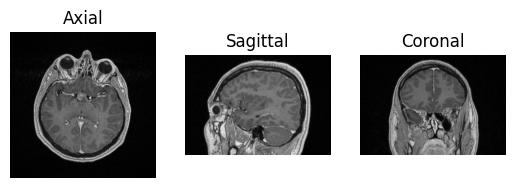

In [257]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

path = '/content/ref_mri.nii.gz'
mri_meta = nib.load(path)
pixDim = mri_meta.header['pixdim'][1:4]
# Following: https://ianmcatee.com/converting-a-nifti-file-to-an-image-sequence-using-python/
aspectRatios = [pixDim[1]/pixDim[2],pixDim[0]/pixDim[2], pixDim[0]/pixDim[1]]

mri = mri_meta.get_fdata()
mri = np.rot90(mri, k=1)
mri = cv2.normalize(mri, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print('voxel size:',mri.shape)

def slicing_with_voxel_spacing(img, aspectRatio, maxdim=512, ismask=False):
    h, w = img.shape
    inter = cv2.INTER_NEAREST if ismask else cv2.INTER_LINEAR
    if h < w:
        img = cv2.resize(img, dsize=(w, int(h/aspectRatio)), interpolation=inter)
    else:
        img = cv2.resize(img, dsize=(int(w/aspectRatio), h))

    return img


img = mri[:,:, 51]
img = slicing_with_voxel_spacing(img, aspectRatios[2], maxdim=512)
print('Axial size:', img.shape)
plt.subplot(131),plt.axis('OFF'), plt.title('Axial'), plt.imshow(mri[:,:, 51], cmap='gray')


img = mri[:,180, :]
img = np.rot90(img)
img = slicing_with_voxel_spacing(img, aspectRatios[1], maxdim=512)
print('Sagittal size:', img.shape)
plt.subplot(132),plt.axis('OFF'), plt.title('Sagittal'), plt.imshow(img, cmap='gray');

img = mri[180,:, :]
img = np.rot90(img)
img = slicing_with_voxel_spacing(img, aspectRatios[0], maxdim=512)
print('Coronal size:', img.shape)
plt.subplot(133),plt.axis('OFF'), plt.title('Coronal'), plt.imshow(img, cmap='gray');

Slicing: our dataset with padding

MRI + Mask

In [150]:
import gdown
url = 'https://drive.google.com/uc?id=1zcvnBscFVI2v5ieAlGGnp0zpX8WmIrD4'
gdown.download(url,'endonasal_mri_patients.zip',quiet=True)
!unzip -q endonasal_mri_patients.zip
!rm -rf /content/endonasal_mri_patients/.DS_Store
!rm -rf /content/endonasal_mri_patients/**/.DS_Store

voxel size: (512, 512, 114)
img_axial: (512, 512) mask_axial (512, 512) classes: [0. 1.]
img_sagittal: (512, 512) mask_sagittal: (512, 512) classes: [0. 2.]
img_coronal: (512, 512) mask_coronal: (512, 512) classes: [0. 1. 2.]


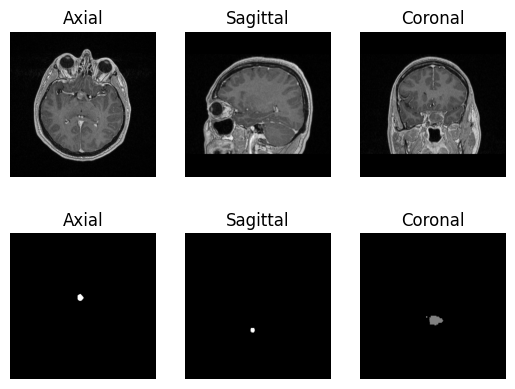

In [256]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

path = '/content/endonasal_mri_patients/mri0066/mri0066_t1c.nii.gz'
mri_meta = nib.load(path)
pixDim = mri_meta.header['pixdim'][1:4]
# Following: https://ianmcatee.com/converting-a-nifti-file-to-an-image-sequence-using-python/
aspectRatios = [pixDim[1]/pixDim[2],pixDim[0]/pixDim[2], pixDim[0]/pixDim[1]] # for the voxel spacing of [0.48828125, 0.48828125, 1.5]  aspectratio: [0.32552084, 0.32552084, 1.0]

mask_path = '/content/endonasal_mri_patients/mri0066/mri0066_mask.nii.gz'
mask_mri = nib.load(mask_path).get_fdata()
mri = mri_meta.get_fdata()

mri = np.rot90(mri, k=1)
mask_mri = np.rot90(mask_mri, k=1)

mri = cv2.normalize(mri, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print('voxel size:',mri.shape)

def slicing_with_voxel_spacing(img, aspectRatio, maxdim=512, ismask=False):
    h, w = img.shape
    inter = cv2.INTER_NEAREST if ismask else cv2.INTER_LINEAR
    if h < w:
        img = cv2.resize(img, dsize=(w, int(h/aspectRatio)), interpolation=inter)
    else:
        img = cv2.resize(img, dsize=(int(w/aspectRatio), h))

    h, w = img.shape
    img = cv2.copyMakeBorder(img, (maxdim-h)//2, (maxdim-h)//2, 0, 0, borderType=cv2.BORDER_CONSTANT, value=0)
    return img

#axial
slice_idx = 51
img_axial = mri[:,:, slice_idx]
mask_axial = mask_mri[:,:, slice_idx]

img_axial = slicing_with_voxel_spacing(img_axial, aspectRatios[2], maxdim=512)
mask_axial = slicing_with_voxel_spacing(mask_axial, aspectRatios[2], maxdim=512, ismask=True)
cv2.imwrite('test_axial.png', img_axial)
cv2.imwrite('test_axial_mask.png', mask_axial)
print('img_axial:',img_axial.shape, 'mask_axial', mask_axial.shape, 'classes:', np.unique(mask_axial))
plt.subplot(231),plt.axis('OFF'), plt.title('Axial'), plt.imshow(img_axial, cmap='gray')
plt.subplot(234),plt.axis('OFF'), plt.title('Axial'), plt.imshow(mask_axial, cmap='gray')

#sagittal
slice_idx = 200
img_sagittal = mri[:,slice_idx,:]
mask_sagittal = mask_mri[:,slice_idx, :]

img_sagittal = np.rot90(img_sagittal, k=1)
mask_sagittal = np.rot90(mask_sagittal, k=1)

img_sagittal = slicing_with_voxel_spacing(img_sagittal, aspectRatios[1], maxdim=512)
mask_sagittal = slicing_with_voxel_spacing(mask_sagittal, aspectRatios[1], maxdim=512, ismask=True)
cv2.imwrite('test_sagittal.png', img_sagittal)
cv2.imwrite('test_sagittal_mask.png', mask_sagittal)
print('img_sagittal:',img_sagittal.shape, 'mask_sagittal:', mask_sagittal.shape, 'classes:', np.unique(mask_sagittal))
plt.subplot(232),plt.axis('OFF'), plt.title('Sagittal'), plt.imshow(img_sagittal, cmap='gray')
plt.subplot(235),plt.axis('OFF'), plt.title('Sagittal'), plt.imshow(mask_sagittal, cmap='gray')

#coronal
img_coronal = mri[slice_idx, :, :]
mask_coronal = mask_mri[slice_idx, :, :]

img_coronal = np.rot90(img_coronal, k=1)
mask_coronal = np.rot90(mask_coronal, k=1)

img_coronal = slicing_with_voxel_spacing(img_coronal, aspectRatios[0], maxdim=512)
mask_coronal = slicing_with_voxel_spacing(mask_coronal, aspectRatios[0], maxdim=512, ismask=True)
cv2.imwrite('test_coronal.png', img_coronal)
cv2.imwrite('test_coronal_mask.png', mask_coronal)
print('img_coronal:',img_coronal.shape, 'mask_coronal:', mask_coronal.shape, 'classes:', np.unique(mask_coronal))
plt.subplot(233),plt.axis('OFF'), plt.title('Coronal'), plt.imshow(img_coronal, cmap='gray')
plt.subplot(236),plt.axis('OFF'), plt.title('Coronal'), plt.imshow(mask_coronal, cmap='gray');
